In [2]:
import numpy as np
A = np.arange(4).reshape((2, 2))
d = np.array((1, 2))
D = np.diag(d)
B = D.dot(A)
d2 = np.expand_dims(d, -1)
C = d2 * A
E = np.dot(A, d)

# now try multiplying the same rank 2 matrix by a stack of vectors
I = np.eye(2)
I[1,1] += 1
B = np.arange(20).reshape((-1, 2))
G = np.einsum('jk,ik->ji', B, I)

# now try multiplying a stack of matrices by a stack of matrices
F = np.tile(I, (5,1,1))
for i in range(5):
    F[i,1,0] += i
H = np.einsum('ijk,ilk->ijl', F, F)

# now try multiplying a stack of matrices by a stack of diagonal (vectors, but interpreted as matrices)
D2 = np.tile(np.array((2, 1)), (5, 1))
U = np.einsum('ijk,ik->ijk', F, D2)

# now try multiplying by the diagonal
ones = np.ones(4).reshape((2, 2))
L = np.einsum('ij,j->ij', ones, d)

# PRINTS
print(H)

[[[ 1.  0.]
  [ 0.  4.]]

 [[ 1.  1.]
  [ 1.  5.]]

 [[ 1.  2.]
  [ 2.  8.]]

 [[ 1.  3.]
  [ 3. 13.]]

 [[ 1.  4.]
  [ 4. 20.]]]


In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import tensorflow as tf
import numpy as np
A = tf.constant(np.arange(8).reshape((2, 2, 2)))
d = tf.constant(np.arange(4).reshape((2, 2)) + 1)
D = tf.linalg.diag(d)
B = tf.matmul(D, A)
d2 = tf.expand_dims(d, -1)
C = d2 * A
E = tf.einsum('ijk,ik->ij', A, d)

# test making a stacked identity
I_ = tf.expand_dims(tf.eye(3), 0)
I = tf.tile(I_, (5, 1, 1))

# testing matrix_band_part
G = tf.constant(np.random.normal(size=(5, 3, 3)))
G_ld = tf.matrix_band_part(G, -1, 0) - tf.matrix_band_part(G, 0, 0)
G_ud = tf.einsum('ijk->ikj', G_ld)

with tf.Session() as sess:
    items = sess.run([G_ld, G_ud])
    
for i in items:
    print(i)
    print(i.shape)
    print('-' * 15)

[[[ 0.          0.          0.        ]
  [ 0.18073091  0.          0.        ]
  [ 0.61671562 -0.16633126  0.        ]]

 [[ 0.          0.          0.        ]
  [-1.24017615  0.          0.        ]
  [-0.02817312 -0.71113017  0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.11160822  0.          0.        ]
  [ 0.52969812  0.47819034  0.        ]]

 [[ 0.          0.          0.        ]
  [-0.57012867  0.          0.        ]
  [ 0.32174775  1.01494114  0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.75442281  0.          0.        ]
  [-0.404102   -0.02424096  0.        ]]]
(5, 3, 3)
---------------
[[[ 0.          0.18073091  0.61671562]
  [ 0.          0.         -0.16633126]
  [ 0.          0.          0.        ]]

 [[ 0.         -1.24017615 -0.02817312]
  [ 0.          0.         -0.71113017]
  [ 0.          0.          0.        ]]

 [[ 0.          0.11160822  0.52969812]
  [ 0.          0.          0.47819034]
  [ 0.          0.          0.        ]]

In [3]:
# TEST IF eigh() IS DIFFERENTIABLE
A = tf.Variable(np.random.normal(size=(5, 5)))
A = tf.matmul(A, A, transpose_b=True)
e, v = tf.linalg.eigh(A)
loss = tf.linalg.norm(tf.einsum('ij,kj->ik', tf.einsum('ij,j->ij', v, e), v) - tf.cast(tf.eye(5), tf.float64))
e, v = e[::-1], v[:, ::-1]
error = tf.linalg.norm(tf.einsum('ij,kj->ik', tf.einsum('ij,j->ij', v, e), v) - A)

opt = tf.train.AdamOptimizer()
step = opt.minimize(loss)

# initialize
with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
    for i in range(10000):
        loss_, error_, _ = sess.run([loss, error, step])
        if i % 1000 == 0:
            print(i, loss_, error_)
        
    A_ = sess.run(A)
    
print(A_)

Instructions for updating:
Colocations handled automatically by placer.
0 13.117019538633755 1.889989626017533e-14
1000 0.8701319239992362 2.3990918362583067e-15
2000 0.0006480205171142193 2.778926301769243e-15
3000 0.0004040228525625498 2.9578909866272168e-15
4000 0.00041364774985927093 2.4293710699900395e-15
5000 0.0004164869189363326 8.023668045907662e-16
6000 0.0004022914262412809 1.7274710493826249e-15
7000 0.00039297807166996244 2.6139652363214464e-15
8000 0.0004937151349739337 3.940121847080485e-15
9000 0.00048272461154584805 2.3398326817927155e-15
[[ 1.00017805e+00  7.31007418e-05 -4.68187045e-05  3.76691969e-04
  -1.60614629e-04]
 [ 7.31007418e-05  9.99864313e-01 -1.53200382e-04 -2.72627534e-04
  -1.58345284e-04]
 [-4.68187045e-05 -1.53200382e-04  1.00009357e+00 -1.19713180e-04
   8.75547846e-05]
 [ 3.76691969e-04 -2.72627534e-04 -1.19713180e-04  9.99896543e-01
   2.55420102e-04]
 [-1.60614629e-04 -1.58345284e-04  8.75547846e-05  2.55420102e-04
   1.00012496e+00]]


In [4]:
# TEST MATRIX STACK x MATRIX STACK
n_stacks = 10
n = 10

# generate matrices
matrices = []
products = []
for i in range(n_stacks):
    matrix = np.random.normal(size=(n, n))
    product = np.dot(matrix, matrix.T)
    matrices.append(matrix)
    products.append(product)
    
matrix_stack = np.concatenate([np.expand_dims(m, axis=0) for m in matrices], axis=0)
product_stack = np.einsum('ijk,ilk->ijl', matrix_stack, matrix_stack)

diffs = []
for i in range(n_stacks):
    diff = np.sum(products[i] - product_stack[i,:,:])
    diffs.append(diff)
    
print(sum(diffs))

7.359998027700598e-15


In [5]:
# TEST MATRIX STACK x VECTOR STACK (REPRESENTING DIAGONALS)
n_stacks = 10
n = 10

# generate matrices
matrices = []
diagonals = []
products = []
for i in range(n_stacks):
    matrix = np.random.normal(size=(n, n))
    diagonal = np.random.normal(size=(n,))
    product = np.dot(matrix, np.diag(diagonal))
    matrices.append(matrix)
    diagonals.append(diagonal)
    products.append(product)
    
matrix_stack = np.concatenate([np.expand_dims(m, axis=0) for m in matrices], axis=0)
diagonals_stack = np.concatenate([np.expand_dims(d, axis=0) for d in diagonals], axis=0)
product_stack = np.einsum('ijk,ik->ijk', matrix_stack, diagonals_stack)

diffs = []
for i in range(n_stacks):
    diff = np.sum(products[i] - product_stack[i,:,:])
    diffs.append(diff)
    
print(sum(diffs))

0.0


In [6]:
# TEST MATRIX STACK x VECTOR STACK (REPRESENTING ACTUAL VECTORS)
n_stacks = 10
n = 10

# generate matrices
matrices = []
vectors = []
products = []
for i in range(n_stacks):
    matrix = np.random.normal(size=(n, n))
    vector = np.random.normal(size=(n,))
    product = np.dot(matrix, vector)
    matrices.append(matrix)
    vectors.append(vector)
    products.append(product)
    
matrix_stack = np.concatenate([np.expand_dims(m, axis=0) for m in matrices], axis=0)
vectors_stack = np.concatenate([np.expand_dims(v, axis=0) for v in vectors], axis=0)
product_stack = np.einsum('ijk,ik->ij', matrix_stack, vectors_stack)

diffs = []
for i in range(n_stacks):
    diff = np.sum(products[i] - product_stack[i])
    diffs.append(diff)
    
print(sum(diffs))

-7.771561172376096e-16


In [7]:
# check numpy broadcasting for row sums
n = 100
x = np.random.normal(size=(n, 100000)) ** 2
x /= np.expand_dims(np.sum(x, axis=1), -1)
print(np.sum(x))

100.0


In [8]:
# check tf broadcasting for row sums
n = 100
e = tf.constant(np.random.normal(size=(n, 10000)) ** 2)
eps = 1e-8
pre_e_t = 1/(e + eps)
e_t = pre_e_t / tf.expand_dims(tf.reduce_sum(pre_e_t, axis=1), -1) #*tf.expand_dims(tf.reduce_sum(e, axis=1), -1)
e_t_sum = tf.reduce_sum(e_t)
e_t_max = tf.maximum(e_t, 20)
with tf.Session() as sess:
    a = sess.run(e_t_max)

In [4]:
# test if our home-made distance function is correct
import numpy as np
from scipy.spatial.distance import cdist

d = 10
n_A = 150
n_B = 320
A = np.random.normal(size=(n_A, d))
B = np.random.normal(size=(n_B, d))

def pairwise_dists(A, B):
    r_A, r_B = np.sum(A*A, 1), np.sum(B*B, 1)

    # turn r into column vector
    r_A, r_B = np.reshape(r_A, [-1, 1]), np.reshape(r_B, [-1, 1])
    D = r_A - 2 * np.matmul(A, B.T) + np.transpose(r_B)
    
    return D

D1 = np.sqrt(pairwise_dists(A, B))
D2 = cdist(A, B)
print(np.linalg.norm(D1 - D2))

8.746584734180662e-14


In [5]:
top = tf.nn.top_k(-D1, k=1)
with tf.Session() as sess:
    A_ = sess.run(top)
    
print(A_)

TopKV2(values=array([[-2.20760803],
       [-1.89196124],
       [-2.40478841],
       [-2.40283179],
       [-2.12267971],
       [-1.32023786],
       [-3.17444782],
       [-2.26010823],
       [-2.08029013],
       [-2.46560077],
       [-1.56886159],
       [-2.24586199],
       [-2.40880905],
       [-1.91046287],
       [-2.57023707],
       [-2.5789597 ],
       [-1.9739789 ],
       [-2.21601739],
       [-2.0482465 ],
       [-2.1590495 ],
       [-2.51070537],
       [-1.87883634],
       [-2.47210444],
       [-3.14499569],
       [-1.88868781],
       [-1.78944999],
       [-2.58307684],
       [-2.19582137],
       [-2.10651386],
       [-2.67799096],
       [-1.7817432 ],
       [-2.18553908],
       [-1.40982023],
       [-1.78104308],
       [-1.15757494],
       [-2.88969345],
       [-1.83249753],
       [-2.0544082 ],
       [-1.70882809],
       [-1.3022388 ],
       [-1.39895045],
       [-1.81108   ],
       [-1.91872268],
       [-1.9235575 ],
       [-2.2209723

In [26]:
D = pairwise_dists(A, A) + 1e-6

k = 1
vals, idxs = tf.nn.top_k(-D, k=k)
range_A = tf.expand_dims(tf.range(idxs.shape[0]), -1)
p = tf.expand_dims(tf.random.uniform(shape=(tf.shape(idxs)[0],), maxval=k, dtype=tf.dtypes.int32), -1)
p = tf.concat([range_A, p], axis=1)
idx = tf.gather_nd(idxs, p)
idx = tf.expand_dims(idx, -1)
A_ = tf.gather_nd(A, idx)
RES = tf.linalg.norm(A_ - A)

with tf.Session() as sess:
    RES_ = sess.run(RES)
    
print(RES_)

0.0


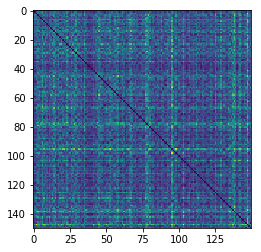

In [27]:
import matplotlib.pyplot as plt
plt.imshow(D)
plt.show()